In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import igraph as ig
import numpy as np
import gpn.utils.graphs as gutils
import random

2025-03-17 15:59:52.394085: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 15:59:52.625214: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 15:59:52.625257: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 15:59:52.626377: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 15:59:52.733438: I tensorflow/core/platform/cpu_feature_g

In [113]:
workspace = "kdey_sis"

g = nx.Graph()

cluster_sizes = np.array([70, 70, 70])
cluster_density = 0.1
cross_cluster_density = 0.001
num_nodes = cluster_sizes.sum()
num_clusters = len(cluster_sizes)

for i in range(num_clusters):
    for j in range(cluster_sizes[i]):
        g.add_node(j + cluster_sizes[:i].sum(), cluster=i)

rnd = np.random.default_rng(42)

for c1 in range(num_clusters):
    for c2 in range(c1, num_clusters):
        density = cross_cluster_density if c1 != c2 else cluster_density
        for i in range(cluster_sizes[c1]):
            for j in range(cluster_sizes[c2]):
                a = i + cluster_sizes[:c1].sum()
                b = j + cluster_sizes[:c2].sum()
                if a != b and rnd.random() < density:
                    g.add_edge(a, b)

gutils.vizualize_in_gephi(g, override=False, workspace=workspace)

In [ ]:
random.seed(42)

groups = np.zeros((num_nodes,))
preds = np.zeros((num_nodes, num_clusters))
trues = np.zeros((num_nodes,), dtype=np.int32)
selected = np.zeros((num_nodes,), dtype=bool)

select_counts = np.zeros((num_clusters,))
select_targets = np.array([2, 4, 3])

for n, attrs in g.nodes(data=True):
    cluster = attrs["cluster"]
    neighbors = list(g.neighbors(n))
    random.shuffle(neighbors)
    true_cluster = cluster
    neigh_clusters = np.array([g.nodes[neighbor]["cluster"] for neighbor in neighbors])
    err = 0
    for neighbor_cluster in neigh_clusters:
        if neighbor_cluster != cluster:
            true_cluster = neighbor_cluster
            err = 1
            break
    pred = np.bincount(neigh_clusters, minlength=3) + 0.1
    factors = np.full(num_clusters, 10.0)
    factors[cluster] = 1.0
    pred *= factors
    temp = 3.0 / pred.sum()
    pred = np.exp(pred * temp)
    pred = pred / pred.sum()
    g.nodes[n]["true_cluster"] = true_cluster
    g.nodes[n]["pred_cluster"] = np.argmax(pred)
    # g.nodes[n]["pred"] = pred
    preds[n] = pred
    trues[n] = true_cluster
    groups[n] = cluster
    g.nodes[n]["err"] = err  # int(np.argmax(pred) != true_cluster)
    s = 0
    if cluster == 1:
        if select_counts[true_cluster] < select_targets[true_cluster]:
            select_counts[true_cluster] += 1
            s = 1
    g.nodes[n]["selected"] = s
    selected[n] = s

gutils.update_vertices_in_gephi(g, workspace=workspace)

/home/clemens/Projects/Graph-Posterior-Network/.venv/lib/python3.10/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


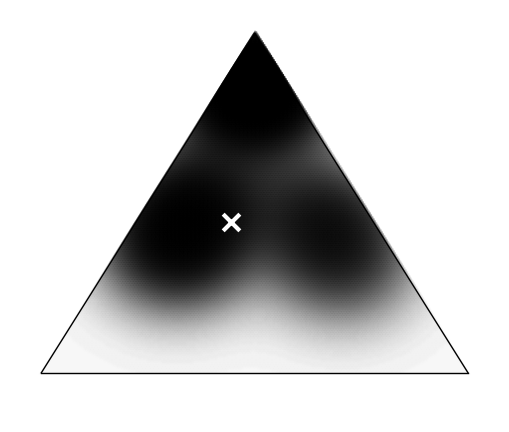

[0.22222222 0.44444444 0.33333333] [0.21788677 0.4450237  0.33708953]


/home/clemens/Projects/Graph-Posterior-Network/.venv/lib/python3.10/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


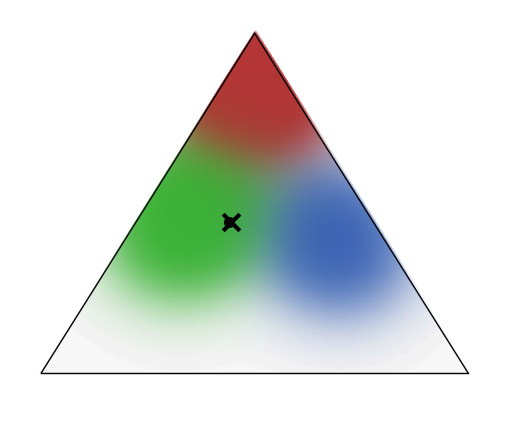

[0.22222222 0.44444444 0.33333333] [3.85802501e-14 1.00000000e+00 2.16493490e-14]


/home/clemens/Projects/Graph-Posterior-Network/.venv/lib/python3.10/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


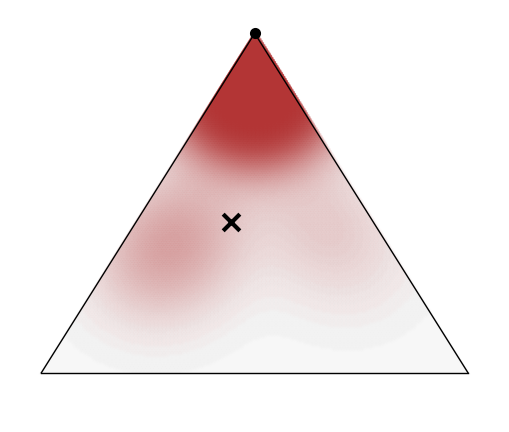

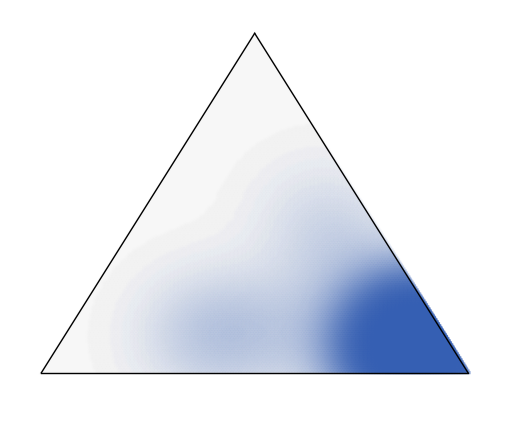

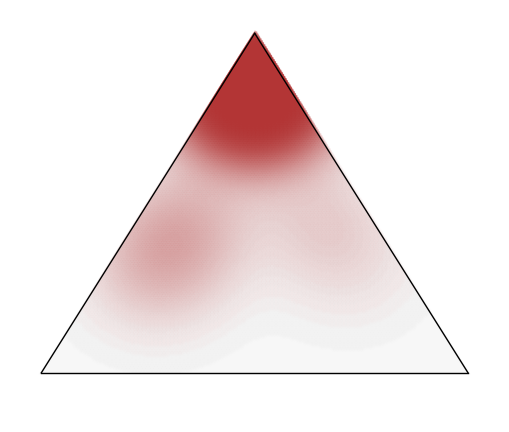

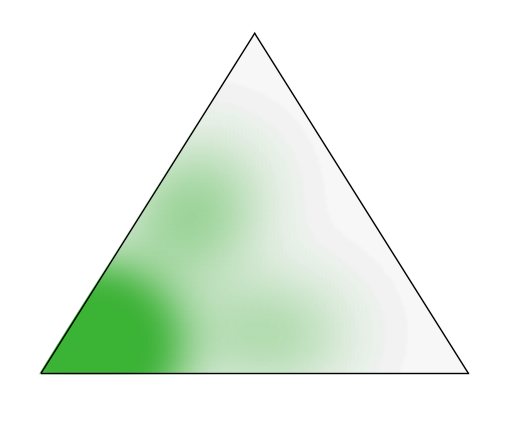

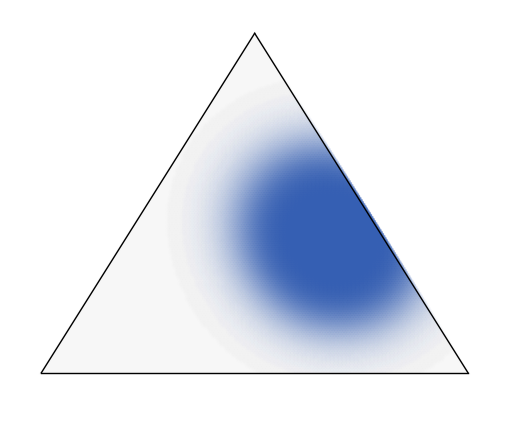

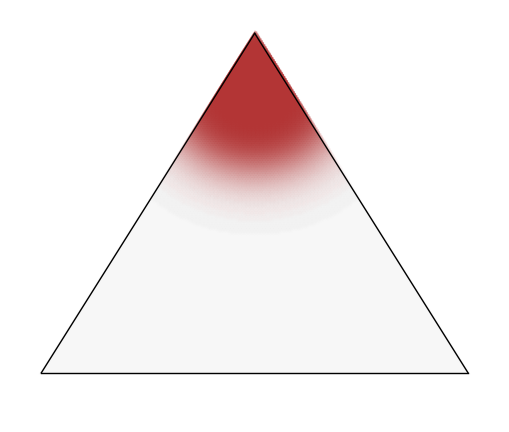

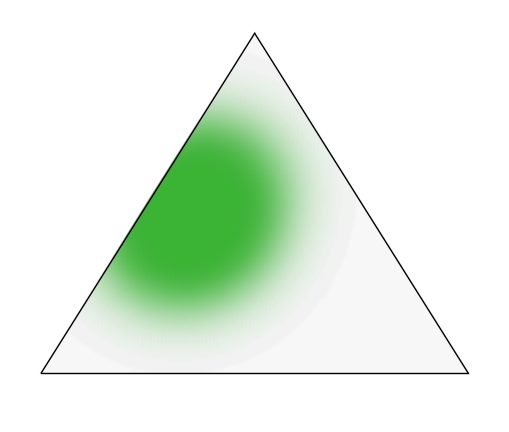

In [182]:
from typing import Any, Literal
from sklearn.neighbors import KernelDensity
import ternary
import matplotlib.pyplot as plt
import quapy.method.aggregative as qma

colors = np.array([[53, 95, 179], [179, 53, 53], [59, 179, 53]]) / 255.0


def get_dists(steps):
    counts = np.zeros((((steps + 1) * (steps + 2)) // 2, 3), dtype=np.int32)
    k = 0
    for i in range(steps + 1):
        for j in range(i, steps + 1):
            counts[k, 0] = i
            counts[k, 1] = j - i
            counts[k, 2] = steps - counts[k, 0] - counts[k, 1]
            k += 1
    return counts


def get_density(
    mask,
    with_target: bool = False,
    with_pred: bool = False,
    color_idx: int | None = None,
):
    preds_masked = preds[mask]
    trues_masked = trues[mask]
    target_dist = np.bincount(trues_masked, minlength=num_clusters)
    target_dist = target_dist / target_dist.sum()
    return dict(
        densities=[KernelDensity(bandwidth=0.15, kernel="gaussian").fit(preds_masked)],
        pred_dist=preds_masked.mean(axis=0),
        target_dist=target_dist,
        with_target=with_target,
        with_pred=with_pred,
        density_colors=colors[None, color_idx] if color_idx is not None else None,
    )


def get_densities():
    res: dict[int | Literal["all"], dict[int, dict[str, Any]]] = {
        group: {
            true: get_density((groups == group) & (trues == true), color_idx=true)
            for true in range(num_clusters)
        }
        for group in range(num_clusters)
    }
    res["all"] = {
        true: get_density(trues == true, color_idx=true) for true in range(num_clusters)
    }
    return res


def plot_density(
    densities: list[KernelDensity],
    pred_dist: np.ndarray,
    target_dist: np.ndarray,
    density_weights: np.ndarray | None = None,
    density_colors: np.ndarray | None = None,
    with_target: bool = False,
    with_pred: bool = False,
    filename: str | None = None,
):
    scale = 160
    fig, ax = plt.subplots()
    _, tax = ternary.figure(ax=ax, scale=scale)
    ratio = 2 / np.sqrt(3)
    size = 2.5
    fig.set_size_inches(size * ratio, size)

    samples = get_dists(scale)

    if density_weights is None:
        density_weights = np.ones((len(densities),))

    if density_colors is None:
        marker_color = "white"
        density_colors = np.zeros((len(densities), 3))
    else:
        marker_color = "black"

    density_weights = density_weights / density_weights.sum()

    scores_agg = np.zeros((samples.shape[0], len(densities)), dtype=np.float64)

    for i, (density, weight) in enumerate(zip(densities, density_weights)):  # type: ignore
        log_scores = density.score_samples(samples / scale)
        scores = np.exp(log_scores)
        scores_agg[:, i] += scores * weight

    max_score = scores_agg.max()
    scores_agg /= max_score

    score_alphas = scores_agg.sum(axis=-1)
    color_weights = scores_agg / score_alphas[:, np.newaxis]
    mixed_colors = color_weights @ density_colors
    rgba = np.hstack((mixed_colors, score_alphas[:, np.newaxis]))
    rgba = np.clip(rgba, 0, 1)

    data = {tuple(p): s for p, s in zip(samples, rgba)}

    tax.heatmap(data, scale=1.0, style="hexagonal", colorbar=False, use_rgba=True)
    if with_target:
        tax.scatter(
            [target_dist * scale],
            marker="x",
            color=marker_color,
            # edgecolors="black",
            label="Target Distribution",
        )
    if with_pred:
        tax.scatter(
            [pred_dist * scale],
            marker=".",
            color=marker_color,
            # edgecolors="black",
            label="Predicted Distribution",
        )
    tax.boundary(linewidth=0.5)
    ax.set_axis_off()
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=600, bbox_inches="tight", transparent=True)

    plt.show()


densities = get_densities()


def kdey_mixture(densities, mask):
    preds_masked = preds[mask]
    trues_masked = trues[mask]
    target_dist = np.bincount(trues_masked, minlength=num_clusters)
    target_dist = target_dist / target_dist.sum()
    kdey = qma.KDEyML(True, random_state=1337)  # type: ignore
    kdey.mix_densities = [
        densities[true]["densities"][0] for true in range(num_clusters)
    ]
    mixture_weights = kdey.aggregate(preds_masked)
    print(target_dist, mixture_weights)
    return dict(
        densities=kdey.mix_densities,
        density_weights=mixture_weights,
        pred_dist=mixture_weights,
        target_dist=target_dist,
        with_target=True,
        with_pred=True,
        density_colors=colors,
    )


plot_density(filename="plots/quant_dm/densities/selected.png", **get_density(selected, with_target=True))  # type: ignore
plot_density(filename="plots/quant_dm/densities/mixture_1.png", **kdey_mixture(densities[1], selected))  # type: ignore
plot_density(filename="plots/quant_dm/densities/mixture_all.png", **kdey_mixture(densities["all"], selected))  # type: ignore

for i in ["all", 1]:
    for j in range(3):
        plot_density(
            filename=f"plots/quant_dm/densities/cond_{i}_{j}.png", **densities[i][j]
        )